# 0D model of low-Atwood, single-mode RTI

Lots of imports.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import bisect
from scipy.special import erf
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many


/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def load_from_archive(names, arch):
    cs = []
    for name in names:
        cs.append(Chest(path      = "{:s}-results".format(name),
                        open      = partial(glopen,      endpoint=arch),
                        open_many = partial(glopen_many, endpoint=arch)))
    scs = [CachedSlict(c) for c in cs]

    ps = []
    for name in names:
        with glopen(
                    "{:s}.json".format(name), mode='r',
                    endpoint = arch,
                    ) as f:
            ps.append(json.load(f))
    if len(names) == 1:
        return cs[0], scs[0], ps[0]
    return cs, scs, ps

We're going to compare/train on model on DNS data.  Here, we list which data sets to use and where they live.

In [3]:
config = Foo()
config.names     = [
#    "Conv/cnv_o8_e32/cnv_o8_e32",
    "Conv/cnv_o4_e64/cnv_o4_e64",    
    "Conv/cnv_o4_e32/cnv_o4_e32",
    "Conv/cnv_o8_e16/cnv_o8_e16",
    "Conv/cnv_o4_e16/cnv_o4_e16",
    ]
config.ref = ["Conv/cnv_o8_e32/cnv_o8_e32",]
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
config.arch_end = "alcf#dtn_mira/projects/HighAspectRTI/experiments"

This opens the data.  Could be rolled into a utility routine.

In [4]:
cs, scs, ps = load_from_archive(config.names, config.arch_end);
rc, rsc, rp = load_from_archive(config.ref, config.arch_end);

The data is remote, so we pre-fetch it for efficiency.

In [5]:
#from interfaces.abstract import AbstractSlice
height = 'H_exp'
#mix = 't_abs_proj_z'
mix = 't_sq_proj_z'
for c,sc in zip(cs, scs):
    c.prefetch(
          sc[:,height].full_keys()
        + sc[:,mix].full_keys()
    )
rc.prefetch(
          rsc[:,height].full_keys()
        + rsc[:,mix].full_keys()
           )
T_end = rsc[:,height].keys()[-1]

In [6]:
from globussh import ls
from os.path import join
times = []
for name in config.names:
    time = 0.
    out_files = ls(join(config.arch_end, name + "*.output"))
    paths = [join(*(name.split("/")[0:-1] + [of,])) for of in out_files]
    with glopen_many(paths, mode='r', endpoint=config.arch_end) as fs:
        for f in fs:
            for line in f.readlines():
                if "total time" in line:
                    time = time + float(line.split()[2])
    times.append(time)

For each run in the data set, interpolate the heights with a spline, take a derivative, and compute the mixedness from the `t_abs_proj_z` field.

In [7]:
delta_H = []
delta_A = []
for sc, p in zip(scs, ps):
    dh = 0.
    da = 0.
    count = 0
    for T in rsc[:,height].keys():
        if T in sc[:,height].keys():
            dh += (sc[T,height] - rsc[T,height])**2
            da += (np.mean(sc[T,mix]) - np.mean(rsc[T,mix]))**2
            count += 1
#        else:
#            print("Missing T={:} in order={:} Courant={}".format(T, p["order"], p["courant"]))
    delta_H.append(np.sqrt(dh/count))
    delta_A.append(np.sqrt(da/count))

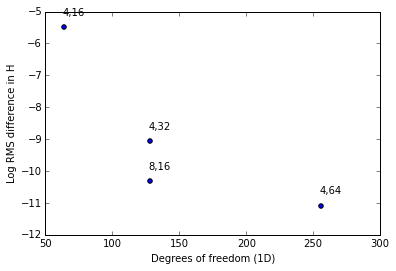

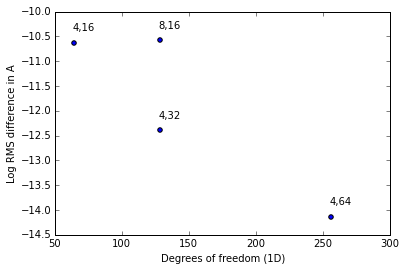

In [8]:
dofs = [p['order']*p['shape_mesh'][0] for p in ps]
errs =  np.log(np.array(delta_H))
labels = ["{:d},{:d}".format(p['order'], p['shape_mesh'][0]) for p in ps]
plt.scatter(dofs, errs)
plt.xlabel('Degrees of freedom (1D)')
plt.ylabel('Log RMS difference in H')
for x, y, label in zip(dofs, errs, labels):
    plt.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.figure()
errs =  np.log(np.array(delta_A))
plt.scatter(dofs, errs)
plt.xlabel('Degrees of freedom (1D)')
plt.ylabel('Log RMS difference in A')
for x, y, label in zip(dofs, errs, labels):
    plt.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')

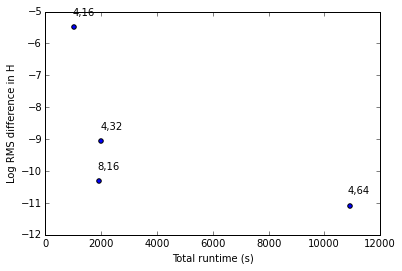

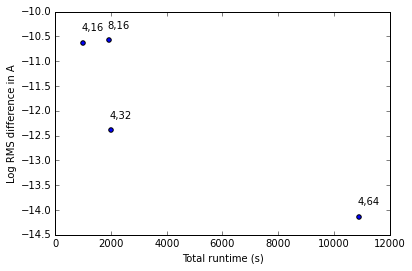

In [9]:
errs =  np.log(np.array(delta_H))
labels = ["{:d},{:d}".format(p['order'], p['shape_mesh'][0]) for p in ps]
plt.scatter(times, errs)
plt.xlabel('Total runtime (s)')
plt.ylabel('Log RMS difference in H')
for x, y, label in zip(times, errs, labels):
    plt.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.figure()
errs =  np.log(np.array(delta_A))
plt.scatter(times, errs)
plt.xlabel('Total runtime (s)')
plt.ylabel('Log RMS difference in A')
for x, y, label in zip(times, errs, labels):
    plt.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')

In [10]:
spls = []
As = []
Frs = []
for sc, p in zip(scs, ps):
    T = np.array(sc[:,height].keys())
    H =  (np.array(sc[:,height].values()) 
#        + 2.*np.sqrt(p["conductivity"] * (T + p['delta']**2/p['conductivity']/16))
           )
    spls.append(UnivariateSpline(T,
                                 H,
                                 k = 3,
                                 s = 0.00000001))
    A = np.array([4*np.mean(x) for x in sc[:,mix].values()])
    As.append(UnivariateSpline(T, A, k=3, s=0.0001))

Frs = [spl.derivative() for spl in spls]
Tss = [np.linspace(sc[:,height].keys()[0], sc[:,height].keys()[-1], 1000) for sc in scs]

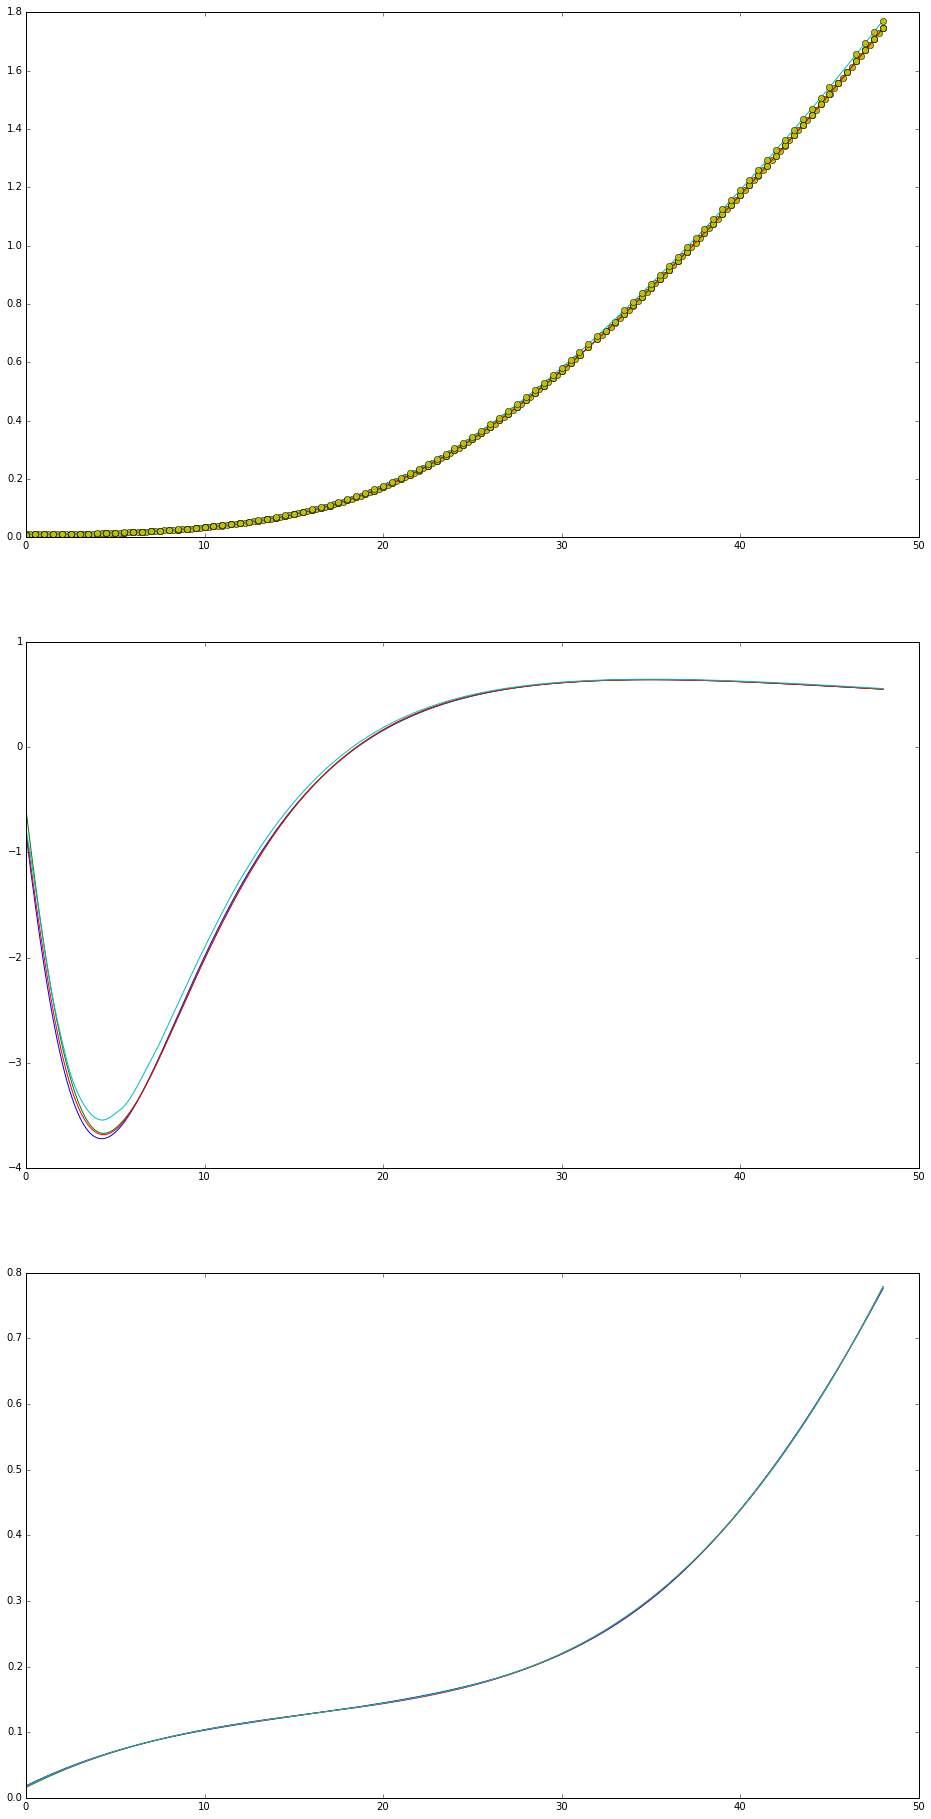

In [11]:
def plot_model(p, spl, V, A, T, sc, axs, nplot):   
        L = 1/p["kmin"]
        Atwood = p["g"] * p["atwood"]
        visc = p["viscosity"]
        diff = p["conductivity"]
        y0 = [p["amp0"]/p["kmin"], 0., p['delta']*L*L/np.sqrt(np.pi)]
        t0 = 0.
        
        Darcy = Atwood * L * L / (113.816 * visc)
        
        H_num = spl(T) / L;
        At_num =1-(p['extent_mesh'][2]- p['extent_mesh'][2]*A(T))/H_num

        axs[0].plot(T, H_num);
        axs[0].plot(sc[:,height].keys(), np.array(sc[:,height].values()) / L, 'yo')

        axs[1].plot(T, At_num);

        axs[2].plot(T, (1-A(T))*p['extent_mesh'][2]);
        #axs[nrow][3].axhline(Darcy/ np.sqrt(Atwood * L));
        #axs[nrow][0].set_xbound(0,6)
        #axs[nrow][0].set_ybound(0,.025)

nplot = 3
fig, axs = plt.subplots(nplot, figsize=(16,8 * len(ps)));
#plot_model(rp, spl, V, A, T, sc, axs, nplot)
for p, spl, V, A, T, sc in zip(ps, spls, Frs, As, Tss, scs):
    plot_model(p, spl, V, A, T, sc, axs, nplot)
